# 1. Install modules

In [2]:
#@title [RUN] Sanity check torch version and GPU runtime

import torch
assert torch.cuda.is_available(), "WARNING! You are running on a non-GPU instance. For this practical a GPU is highly recommended."
REQUIRED_VERSION = "1.13.1+cu116"
TORCH_VERSION = torch.__version__
CUDA_VERSION = TORCH_VERSION.split("+")

if TORCH_VERSION != REQUIRED_VERSION:
  print(f"Detected torch version {TORCH_VERSION}, but notebook was created for {REQUIRED_VERSION}")
  print(f"Attempting installation of {REQUIRED_VERSION}")
  !pip install torch==1.13.1+cu116
print("Correct version of torch detected. You are running on a machine with GPU.")


Correct version of torch detected. You are running on a machine with GPU.


In [3]:
#@title [RUN] Install required python libraries
import os

# Install PyTorch Geometric and other libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Installing torch scatter")
    !pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
    print("Installing torch sparse")
    !pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html
    print("Installing torch geometric")
    !pip install -q torch-geometric==2.0.3
    print("Installing molecule relevant libraries.")
    !pip install -q rdkit-pypi==2021.9.4
    !pip install -q py3Dmol==1.8.0


Installing torch scatter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 47.9 MB/s eta 0:00:00
Installing torch sparse
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 31.6 MB/s eta 0:00:00
Installing torch geometric
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.4/370.4 KB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.0/527.0 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 KB 5.2 MB/s eta 0:00:00
Installing molecule relevant libraries.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 58.5 MB/s eta 0:00:00


In [4]:
#@title [RUN] Import python modules

import os
import sys
import time
import random
import numpy as np

from scipy.stats import ortho_group

import torch
import torch.nn.functional as F
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential, Sigmoid

import torch_geometric
from torch_geometric.data import Data
from torch_geometric.data import Batch
from torch_geometric.datasets import QM9
import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, to_dense_adj, dense_to_sparse
from torch_geometric.loader import DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.datasets import QM9
from torch_scatter import scatter

import rdkit.Chem as Chem
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem import QED, Crippen, rdMolDescriptors, rdmolops
from rdkit.Chem.Draw import IPythonConsole

import py3Dmol
from rdkit.Chem import AllChem

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from google.colab import files
from IPython.display import HTML

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

All imports succeeded.
Python version 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
PyTorch version 1.13.1+cu116
PyG version 2.0.3


In [5]:
#@title [RUN] Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


In [6]:
#@title [RUN] Helper functions for data preparation

class SetTarget:
    """
    This transform modifies the labels vector per data sample to only keep 
    the label for a specific target (there are 19 targets in QM9).

    Note: for this practical, we have hardcoded the target to be target #0,
    i.e. the electric dipole moment of a drug-like molecule.
    (https://en.wikipedia.org/wiki/Electric_dipole_moment)
    """
    def __call__(self, data):
        target = 0 # we hardcoded choice of target  
        data.y = data.y[:, target]
        return data


class CompleteGraph:
    """
    This transform adds all pairwise edges into the edge index per data sample, 
    then removes self loops, i.e. it builds a fully connected or complete graph
    """
    def __call__(self, data):
        device = data.edge_index.device

        row = torch.arange(data.num_nodes, dtype=torch.long, device=device)
        col = torch.arange(data.num_nodes, dtype=torch.long, device=device)

        row = row.view(-1, 1).repeat(1, data.num_nodes).view(-1)
        col = col.repeat(data.num_nodes)
        edge_index = torch.stack([row, col], dim=0)

        edge_attr = None
        if data.edge_attr is not None:
            idx = data.edge_index[0] * data.num_nodes + data.edge_index[1]
            size = list(data.edge_attr.size())
            size[0] = data.num_nodes * data.num_nodes
            edge_attr = data.edge_attr.new_zeros(size)
            edge_attr[idx] = data.edge_attr

        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        data.edge_attr = edge_attr
        data.edge_index = edge_index

        return data

print("Helper functions loaded.")

Helper functions loaded.


In [7]:
#@title [RUN] Helper functions for visualization

allowable_atoms = [
    "H",
    "C",
    "N",
    "O",
    "F",
    "C",
    "Cl",
    "Br",
    "I",
    "H", 
    "Unknown",
]

def to_atom(t):
    try:
        return allowable_atoms[int(t.argmax())]
    except:
        return "C"


def to_bond_index(t):
    t_s = t.squeeze()
    return [1, 2, 3, 4][
        int(
            torch.dot(
                t_s,
                torch.tensor(
                    range(t_s.size()[0]), dtype=torch.float, device=t.device
                ),
            ).item()
        )
    ]

def to_rdkit(data, device=None):
    has_pos = False
    node_list = []
    for i in range(data.x.size()[0]):
        node_list.append(to_atom(data.x[i][:5]))

    # create empty editable mol object
    mol = Chem.RWMol()
    # add atoms to mol and keep track of index
    node_to_idx = {}
    invalid_idx = set([])
    for i in range(len(node_list)):
        if node_list[i] == "Stop" or node_list[i] == "H":
            invalid_idx.add(i)
            continue
        a = Chem.Atom(node_list[i])
        molIdx = mol.AddAtom(a)
        node_to_idx[i] = molIdx

    added_bonds = set([])
    for i in range(0, data.edge_index.size()[1]):
        ix = data.edge_index[0][i].item()
        iy = data.edge_index[1][i].item()
        bond = to_bond_index(data.edge_attr[i])  # <font color='red'>TODO</font> fix this
        # bond = 1
        # add bonds between adjacent atoms

        if data.edge_attr[i].sum() == 0:
          continue

        if (
            (str((ix, iy)) in added_bonds)
            or (str((iy, ix)) in added_bonds)
            or (iy in invalid_idx or ix in invalid_idx)
        ):
            continue
        # add relevant bond type (there are many more of these)

        if bond == 0:
            continue
        elif bond == 1:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 2:
            bond_type = Chem.rdchem.BondType.DOUBLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 3:
            bond_type = Chem.rdchem.BondType.TRIPLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)
        elif bond == 4:
            bond_type = Chem.rdchem.BondType.SINGLE
            mol.AddBond(node_to_idx[ix], node_to_idx[iy], bond_type)

        added_bonds.add(str((ix, iy)))

    if has_pos:
        conf = Chem.Conformer(mol.GetNumAtoms())
        for i in range(data.pos.size(0)):
            if i in invalid_idx:
                continue
            p = Point3D(
                data.pos[i][0].item(),
                data.pos[i][1].item(),
                data.pos[i][2].item(),
            )
            conf.SetAtomPosition(node_to_idx[i], p)
        conf.SetId(0)
        mol.AddConformer(conf)

    # Convert RWMol to Mol object
    mol = mol.GetMol()
    mol_frags = rdmolops.GetMolFrags(mol, asMols=True, sanitizeFrags=False)
    largest_mol = max(mol_frags, default=mol, key=lambda m: m.GetNumAtoms())
    return largest_mol


def MolTo3DView(mol, size=(300, 300), style="stick", surface=False, opacity=0.5):
    """Draw molecule in 3D
    
    Args:
    ----
        mol: rdMol, molecule to show
        size: tuple(int, int), canvas size
        style: str, type of drawing molecule
               style can be 'line', 'stick', 'sphere', 'carton'
        surface, bool, display SAS
        opacity, float, opacity of surface, range 0.0-1.0
    Return:
    ----
        viewer: py3Dmol.view, a class for constructing embedded 3Dmol.js views in ipython notebooks.
    """
    assert style in ('line', 'stick', 'sphere', 'carton')

    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)
    viewer = py3Dmol.view(width=size[0], height=size[1])
    viewer.addModel(mblock, 'mol')
    viewer.setStyle({style:{}})
    if surface:
        viewer.addSurface(py3Dmol.SAS, {'opacity': opacity})
    viewer.zoomTo()
    return viewer

def smi2conf(smiles):
    '''Convert SMILES to rdkit.Mol with 3D coordinates'''
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol)
        AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
        return mol
    else:
        return None

print("Helper functions added.")

Helper functions added.


In [8]:
# For storing experimental results over the course of the practical
RESULTS = {}
DF_RESULTS = pd.DataFrame(columns=["Test MAE", "Val MAE", "Epoch", "Model"])

# 2. Load QM9 dataset

In [9]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
    path = './qm9'
    target = 0

    # Transforms which are applied during data loading:
    # (1) Fully connect the graphs, (2) Select the target/label
    transform = T.Compose([CompleteGraph(), SetTarget()])
    
    # Load the QM9 dataset with the transforms defined
    dataset = QM9(path, transform=transform)

    # Normalize targets per data sample to mean = 0 and std = 1.
    mean = dataset.data.y.mean(dim=0, keepdim=True)
    std = dataset.data.y.std(dim=0, keepdim=True)
    dataset.data.y = (dataset.data.y - mean) / std
    mean, std = mean[:, target].item(), std[:, target].item()

Extracting qm9/raw/qm9.zip
Processing...
100%|██████████| 133885/133885 [03:17<00:00, 679.38it/s]
Done!


## Load sparse dataset for reference

In [10]:
# Load QM9 dataset with sparse graphs (by removing the full graphs transform)
sparse_dataset = QM9(path, transform=SetTarget())

# Normalize targets per data sample to mean = 0 and std = 1.
mean = sparse_dataset.data.y.mean(dim=0, keepdim=True)
std = sparse_dataset.data.y.std(dim=0, keepdim=True)
sparse_dataset.data.y = (sparse_dataset.data.y - mean) / std
mean, std = mean[:, target].item(), std[:, target].item()

# Split datasets (3K subset)
train_dataset_sparse = sparse_dataset[:1000]

In [ ]:
data = train_dataset_sparse[999]
print(data)

Data(x=[11, 11], edge_index=[2, 22], edge_attr=[22, 4], y=[1], pos=[11, 3], z=[11], name='gdb_1026', idx=[1])


# 3. Data Preparation and Splitting

In [11]:
print(f"Total number of samples: {len(dataset)}.")

# Split datasets (in case of using the full dataset)
# test_dataset = dataset[:10000]
# val_dataset = dataset[10000:20000]
# train_dataset = dataset[20000:]

# Split datasets (our 3K subset)
train_dataset = dataset[:1000]
val_dataset = dataset[1000:2000]
test_dataset = dataset[2000:3000]
print(f"Created dataset splits with {len(train_dataset)} training, {len(val_dataset)} validation, {len(test_dataset)} test samples.")

# Create dataloaders with batch size = 32
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Total number of samples: 130831.
Created dataset splits with 1000 training, 1000 validation, 1000 test samples.


**Atom features (`data.x`)** - $\mathbb{R}^{|V| \times 11}$
- 1st-5th features: Atom type (one-hot: H, C, N, O, F)
- 6th feature (also `data.z`): Atomic number (number of protons).
- 7th feature: Aromatic (binary)
- 8th-10th features: Electron orbital hybridization (one-hot: sp, sp2, sp3)
- 11th feature: Number of hydrogens

**Edge Index (`data.edge_index`)** - $\mathbb{R}^{2×|E|}$
- A tensor of dimensions 2 x `num_edges` that describe the edge connectivity of the graph

**Edge features (`data.edge_attr`)** - $\mathbb{R}^{|E|\times 4}$
- 1st-4th features: bond type (one-hot: single, double, triple, aromatic)

**Atom positions (`data.pos`)** - $\mathbb{R}^{|V|\times 3}$
- 3D coordinates of each atom . (We will talk about their importance later in the practical.)

**Target (`data.y`)** - $\mathbb{R}^{1}$
- A scalar value corresponding to the molecules electric dipole moment

We loaded the **fully-connected graphs** (i.e. all atoms in a molecule are connected to each other, except self-loops). The information about the molecule structures will be available to the models through the edge features (`data.edge_attr`) as follows:
- When two atoms are physically connected, the edge attributes indicate the **bond type** (single, double, triple, or aromatic) through a one-hot vector.
- When two atoms are not physically connected, **all edge attributes** are **zero**.
We will later study the advantages/downsides of fully-connected adjacency matrices versus sparse adjacency matrices (where an edge between two atoms is present only when there exists a physical connection between them).

Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:
Data(x=[11, 11], edge_index=[2, 110], edge_attr=[110, 4], y=[1], pos=[11, 3], z=[11], name='gdb_1026', idx=[1])


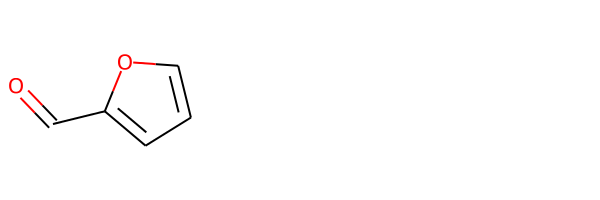

In [ ]:
data = train_dataset[999] # one data sample, i.e. molecular graph
print("Let us print all the attributes (along with their shapes) that our PyG molecular graph contains:")
print(data)
Chem.Draw.MolsToGridImage([to_rdkit(data)])


## Carbon Backbone Rewiring

Since the loaded data is already fully connected graph, we only need to delete the edges and corresponding edge attributes.

In [12]:
import random
from torch_geometric.data import Data


In [22]:
# define function that only allow carbons to fully connect and create new dataset
def carbon_connect(dataset, sparse_dataset):

    new_dataset = []
    counter_dataset = []
    idx = 0
    for data in dataset:
        data_copy = Data.clone(data)
        sparse_data = sparse_dataset[idx]
        # pick out all the virtual edges in the graph
        virtual_edges_index = torch.index_select(data.edge_index, 1, torch.tensor([i for i in range(data.edge_index.shape[1]) if torch.sum(data.edge_attr[i]) == 0]))

        # pick out all carbon nodes
        carbon_nodes = []
        for node in range(data.x.shape[0]):
            if data.x[node,1] == 1:
                carbon_nodes.append(node)

        # crate carbon rewired graph that keeps only carbon related edges, add to new dataset
        carbon_edge_index = torch.index_select(virtual_edges_index, 1, torch.tensor([i for i in range(virtual_edges_index.shape[1]) if virtual_edges_index[0,i] in carbon_nodes or virtual_edges_index[1,i] in carbon_nodes]))
        carbon_edge_attr = torch.zeros(carbon_edge_index.shape[1],4)
        data_copy.edge_index = torch.cat((sparse_data.edge_index, carbon_edge_index), dim = 1)
        data_copy.edge_attr = torch.cat((sparse_data.edge_attr, carbon_edge_attr), dim = 0)
        new_dataset.append(data_copy)

        # create countering random connection graph dataset
        data_copy_ = Data.clone(data)
        extra_edge_num = carbon_edge_index.shape[1]//2
        print(extra_edge_num)
        virtual_edges_list = [virtual_edges_index[:, i].unsqueeze(dim = 1) for i in range(virtual_edges_index.shape[1])]
        sampled_edge_index = []
        for j in range(extra_edge_num):
            print(j)
            sample = random.choice(virtual_edges_list)

            # check if repeated edges are sampled
            sample_np = sample.numpy()

            while np.any([np.array_equal(sample_np, tensor.numpy()) for tensor in sampled_edge_index]):
                sample = random.choice(virtual_edges_list)


            # append both directions
            sampled_edge_index.append(sample)
            sampled_edge_index.append(torch.tensor([sample[1], sample[0]]).unsqueeze(dim = 1))

        sampled_edge_index = torch.cat(sampled_edge_index, dim = 1)
        data_copy_.edge_index = torch.cat((sparse_data.edge_index, sampled_edge_index),dim = 1)
        data_copy_.edge_attr = data_copy.edge_attr

        counter_dataset.append(data_copy_)
        idx += 1
    return new_dataset, counter_dataset

In [33]:
print(train_dataset[9],train_dataset_sparse[9])
carbon_connect([train_dataset[9]], [train_dataset_sparse[9]])

Data(x=[6, 11], edge_index=[2, 30], edge_attr=[30, 4], y=[1], pos=[6, 3], z=[6], name='gdb_10', idx=[1]) Data(x=[6, 11], edge_index=[2, 10], edge_attr=[10, 4], y=[1], pos=[6, 3], z=[6], name='gdb_10', idx=[1])
4
0
1


KeyboardInterrupt: ignored

In [ ]:
train_dataset[99]

Data(x=[13, 11], edge_index=[2, 156], edge_attr=[156, 4], y=[1], pos=[13, 3], z=[13], name='gdb_103', idx=[1])

In [ ]:
train_dataset_carbon, val_dataset_carbon, test_dataset_carbon = carbon_connect(train_dataset), carbon_connect(val_dataset), carbon_connect(test_dataset)

In [ ]:
# Create dataloaders with batch size = 32
train_loader_carbon = DataLoader(train_dataset_carbon, batch_size=32, shuffle=True)
val_loader_carbon = DataLoader(val_dataset_carbon, batch_size=32, shuffle=False)
test_loader_carbon = DataLoader(test_dataset_carbon, batch_size=32, shuffle=False)

# Define GNN Model

In [ ]:
class MPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # MLP `\psi` for computing messages `m_ij`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: (2d + d_e) -> d
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )
        
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # Implemented as a stack of Linear->BN->ReLU->Linear->BN->ReLU
        # dims: 2d -> d
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )

    def forward(self, h, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        As our MPNNLayer class inherits from the PyG MessagePassing parent class,
        we simply need to call the `propagate()` function which starts the 
        message passing procedure: `message()` -> `aggregate()` -> `update()`.
        
        The MessagePassing class handles most of the logic for the implementation.
        To build custom GNNs, we only need to define our own `message()`, 
        `aggregate()`, and `update()` functions (defined subsequently).

        Args:
            h: (n, d) - initial node features
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: (n, d) - updated node features
        """
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr)
        return out

    def message(self, h_i, h_j, edge_attr):
        """Step (1) Message

        The `message()` function constructs messages from source nodes j 
        to destination nodes i for each edge (i, j) in `edge_index`.

        The arguments can be a bit tricky to understand: `message()` can take 
        any arguments that were initially passed to `propagate`. Additionally, 
        we can differentiate destination nodes and source nodes by appending 
        `_i` or `_j` to the variable name, e.g. for the node features `h`, we
        can use `h_i` and `h_j`. 
        
        This part is critical to understand as the `message()` function
        constructs messages for each edge in the graph. The indexing of the
        original node features `h` (or other node variables) is handled under
        the hood by PyG.

        Args:
            h_i: (e, d) - destination node features, essentially h[edge_index[0]]
            h_j: (e, d) - source node features, essentially h[edge_index[1]]
            edge_attr: (e, d_e) - edge features
        
        Returns:
            msg: (e, d) - messages `m_ij` passed through MLP `\psi`
        """
        msg = torch.cat([h_i, h_j, edge_attr], dim=-1)
        return self.mlp_msg(msg)
    
    def aggregate(self, inputs, index):
        """Step (2) Aggregate

        The `aggregate` function aggregates the messages from neighboring nodes,
        according to the chosen aggregation function ('sum' by default).

        Args:
            inputs: (e, d) - messages `m_ij` from destination to source nodes
            index: (e, 1) - list of source nodes for each edge/message in `input`

        Returns:
            aggr_out: (n, d) - aggregated messages `m_i`
        """
        return scatter(inputs, index, dim=self.node_dim, reduce=self.aggr)
    
    def update(self, aggr_out, h):
        """
        Step (3) Update

        The `update()` function computes the final node features by combining the 
        aggregated messages with the initial node features.

        `update()` takes the first argument `aggr_out`, the result of `aggregate()`, 
        as well as any optional arguments that were initially passed to 
        `propagate()`. E.g. in this case, we additionally pass `h`.

        Args:
            aggr_out: (n, d) - aggregated messages `m_i`
            h: (n, d) - initial node features

        Returns:
            upd_out: (n, d) - updated node features passed through MLP `\phi`
        """
        upd_out = torch.cat([h, aggr_out], dim=-1)
        return self.mlp_upd(upd_out)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')

In [ ]:
class MPNNModel(Module):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(MPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        
        for conv in self.convs:
            h = h + conv(h, data.edge_index, data.edge_attr) # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

In [ ]:
class EquivariantMPNNLayer(MessagePassing):
    def __init__(self, emb_dim=64, edge_dim=4, aggr='add'):
        """Message Passing Neural Network Layer

        This layer is equivariant to 3D rotations and translations.

        Args:
            emb_dim: (int) - hidden dimension `d`
            edge_dim: (int) - edge feature dimension `d_e`
            aggr: (str) - aggregation function `\oplus` (sum/mean/max)
        """
        # Set the aggregation function
        super().__init__(aggr=aggr)

        self.emb_dim = emb_dim
        self.edge_dim = edge_dim

        # ============ YOUR CODE HERE ==============
        # Define the MLPs constituting your new layer.
        # At the least, you will need `\psi` and `\phi` 
        # (but their definitions may be different from what
        # we used previously).
        #
        self.mlp_msg = Sequential(
            Linear(2*emb_dim + edge_dim + 1, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )  # MLP `\psi`
        self.mlp_upd = Sequential(
            Linear(2*emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(), 
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU()
          )  # MLP `\phi`

        # Define an additional MLP which maps the node message to a scalar, which
        # acts as a coefficient in calculating the coordinate messages.
        self.mlp_msg_x = Sequential(
            Linear(emb_dim, emb_dim), BatchNorm1d(emb_dim), ReLU(),
            Linear(emb_dim, 1), Sigmoid()
          )  # MLP `\psi_x`

        # MLP `\psi` for computing messages `m_ij`
        # dims: d -> 1
        # MLP `\phi` for computing updated node features `h_i^{l+1}`
        # dims: 2d -> d
        # MLP `\psi_x` for computing coordinate message 
        # ===========================================

    def forward(self, h, pos, edge_index, edge_attr):
        """
        The forward pass updates node features `h` via one round of message passing.

        Args:
            h: (n, d) - initial node features
            pos: (n, 3) - initial node coordinates
            edge_index: (e, 2) - pairs of edges (i, j)
            edge_attr: (e, d_e) - edge features

        Returns:
            out: [(n, d),(n,3)] - updated node features
        """
        # ============ YOUR CODE HERE ==============
        # Notice that the `forward()` function has a new argument 
        # `pos` denoting the initial node coordinates. Your task is
        # to update the `propagate()` function in order to pass `pos`
        # to the `message()` function along with the other arguments.
        #
        out = self.propagate(edge_index, h=h, edge_attr=edge_attr, pos = pos)
        return out
        # ==========================================

    # ============ YOUR CODE HERE ==============
    # Write custom `message()`, `aggregate()`, and `update()` functions
    # which ensure that the layer is 3D rotation and translation equivariant.
    #
    # We are now updating both node features and coordinates in each layer, therefore 
    # there are two outputs for message, aggregate and update functions respectively.
    def message(self, h_i, h_j, edge_attr, pos_i, pos_j):

        # compute squared distance between destination and source nodes
        dis_ij = torch.sum(torch.pow((pos_i - pos_j),2),-1).reshape(-1,1)

        # compute the vector between destination and source nodes
        dir_ij = pos_i - pos_j

        msg = torch.cat([h_i, h_j, edge_attr, dis_ij], dim = 1)

        # map the node feature message to a scalar psi_x
        psi_x = self.mlp_msg_x(self.mlp_msg(msg))

        # the coordinate message is chosen to be scalar projection of the node feature 
        # message times the directional vector between destination and source nodes
        coor_msg = psi_x * dir_ij

        # return both node feature messages and coordinate messages
        return (self.mlp_msg(msg), coor_msg)
    #
    def aggregate(self, inputs, index):
        # aggregation for node feature messages
        agg_1 = scatter(inputs[0], index, dim=self.node_dim, reduce=self.aggr)

        # aggregation for coordinate messages: mean
        agg_2 = scatter(inputs[1], index, dim=self.node_dim, reduce="mean")

        return (agg_1, agg_2)
    #
    def update(self, aggr_out, h, pos):

        # update of node features
        upd_out_1 = torch.cat([h, aggr_out[0]], dim=-1)

        # update of coordinates
        upd_out_2 = aggr_out[1] + pos
        
        return (self.mlp_upd(upd_out_1),upd_out_2)
    # ==========================================

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}(emb_dim={self.emb_dim}, aggr={self.aggr})')


class FinalMPNNModel(MPNNModel):
    def __init__(self, num_layers=4, emb_dim=64, in_dim=11, edge_dim=4, out_dim=1):
        """Message Passing Neural Network model for graph property prediction

        This model uses both node features and coordinates as inputs, and
        is invariant to 3D rotations and translations (the constituent MPNN layers
        are equivariant to 3D rotations and translations).

        Args:
            num_layers: (int) - number of message passing layers `L`
            emb_dim: (int) - hidden dimension `d`
            in_dim: (int) - initial node feature dimension `d_n`
            edge_dim: (int) - edge feature dimension `d_e`
            out_dim: (int) - output dimension (fixed to 1)
        """
        super().__init__()
        
        # Linear projection for initial node features
        # dim: d_n -> d
        self.lin_in = Linear(in_dim, emb_dim)
        
        # Stack of MPNN layers
        self.convs = torch.nn.ModuleList()
        for layer in range(num_layers):
            self.convs.append(EquivariantMPNNLayer(emb_dim, edge_dim, aggr='add'))
        
        # Global pooling/readout function `R` (mean pooling)
        # PyG handles the underlying logic via `global_mean_pool()`
        self.pool = global_mean_pool

        # Linear prediction head
        # dim: d -> out_dim
        self.lin_pred = Linear(emb_dim, out_dim)
        
    def forward(self, data):
        """
        Args:
            data: (PyG.Data) - batch of PyG graphs

        Returns: 
            out: (batch_size, out_dim) - prediction for each graph
        """
        h = self.lin_in(data.x) # (n, d_n) -> (n, d)
        pos = data.pos
        
        for conv in self.convs:
            # Message passing layer
            h_update, pos_update = conv(h, pos, data.edge_index, data.edge_attr)
            
            # Update node features
            h = h + h_update # (n, d) -> (n, d)
            # Note that we add a residual connection after each MPNN layer
            
            # Update node coordinates
            pos = pos_update # (n, 3) -> (n, 3)

        h_graph = self.pool(h, data.batch) # (n, d) -> (batch_size, d)

        out = self.lin_pred(h_graph) # (batch_size, d) -> (batch_size, 1)

        return out.view(-1)

# Training

In [ ]:
#@title [RUN] Helper functions for managing experiments, training, and evaluating models.

def train(model, train_loader, optimizer, device):
    model.train()
    loss_all = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.mse_loss(y_pred, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_loader.dataset)


def eval(model, loader, device):
    model.eval()
    error = 0

    for data in loader:
        data = data.to(device)
        with torch.no_grad():
            y_pred = model(data)
            # Mean Absolute Error using std (computed when preparing data)
            error += (y_pred * std - data.y * std).abs().sum().item()
    return error / len(loader.dataset)


def run_experiment(model, model_name, train_loader, val_loader, test_loader, n_epochs=100):
    
    print(f"Running experiment for {model_name}, training on {len(train_loader.dataset)} samples for {n_epochs} epochs.")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print("\nModel architecture:")
    print(model)
    total_param = 0
    for param in model.parameters():
        total_param += np.prod(list(param.data.size()))
    print(f'Total parameters: {total_param}')
    model = model.to(device)

    # Adam optimizer with LR 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # LR scheduler which decays LR when validation metric doesn't improve
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.9, patience=5, min_lr=0.00001)
    
    print("\nStart training:")
    best_val_error = None
    perf_per_epoch = [] # Track Test/Val MAE vs. epoch (for plotting)
    t = time.time()
    for epoch in range(1, n_epochs+1):
        # Call LR scheduler at start of each epoch
        lr = scheduler.optimizer.param_groups[0]['lr']

        # Train model for one epoch, return avg. training loss
        loss = train(model, train_loader, optimizer, device)
        
        # Evaluate model on validation set
        val_error = eval(model, val_loader, device)
        
        if best_val_error is None or val_error <= best_val_error:
            # Evaluate model on test set if validation metric improves
            test_error = eval(model, test_loader, device)
            best_val_error = val_error

        if epoch % 10 == 0:
            # Print and track stats every 10 epochs
            print(f'Epoch: {epoch:03d}, LR: {lr:5f}, Loss: {loss:.7f}, '
                  f'Val MAE: {val_error:.7f}, Test MAE: {test_error:.7f}')
        
        scheduler.step(val_error)
        perf_per_epoch.append((test_error, val_error, epoch, model_name))
    
    t = time.time() - t
    train_time = t/60
    print(f"\nDone! Training took {train_time:.2f} mins. Best validation MAE: {best_val_error:.7f}, corresponding test MAE: {test_error:.7f}.")
    
    return best_val_error, test_error, train_time, perf_per_epoch

In [ ]:
model = FinalMPNNModel(num_layers=4, emb_dim=59, in_dim=11, edge_dim=4, out_dim=1)

model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, # "MPNN w/ Features and Coordinates (Equivariant Layers)", 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for FinalMPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
FinalMPNNModel(
  (lin_in): Linear(in_features=11, out_features=59, bias=True)
  (convs): ModuleList(
    (0): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (1): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (2): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (3): EquivariantMPNNLayer(emb_dim=59, aggr=add)
  )
  (lin_pred): Linear(in_features=59, out_features=1, bias=True)
)
Total parameters: 103196

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.2273386, Val MAE: 1.2132406, Test MAE: 0.6499045
Epoch: 020, LR: 0.001000, Loss: 0.1346457, Val MAE: 0.6747914, Test MAE: 0.5007994
Epoch: 030, LR: 0.000900, Loss: 0.0796320, Val MAE: 0.6432015, Test MAE: 0.4492815
Epoch: 040, LR: 0.000810, Loss: 0.0587108, Val MAE: 0.5408876, Test MAE: 0.4072644
Epoch: 050, LR: 0.000729, Loss: 0.0446798, Val MAE: 0.4811877, Test MAE: 0.3746405
Epoch: 060, LR: 0.000590, Loss: 0.0443795, Val MAE: 0.4668292,

<ipython-input-91-67bcb2fcded8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


In [ ]:
model = FinalMPNNModel(num_layers=4, emb_dim=59, in_dim=11, edge_dim=4, out_dim=1)


model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, # "MPNN w/ Features and Coordinates (Equivariant Layers)", 
    train_loader_carbon,
    val_loader_carbon, 
    test_loader_carbon,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for FinalMPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
FinalMPNNModel(
  (lin_in): Linear(in_features=11, out_features=59, bias=True)
  (convs): ModuleList(
    (0): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (1): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (2): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (3): EquivariantMPNNLayer(emb_dim=59, aggr=add)
  )
  (lin_pred): Linear(in_features=59, out_features=1, bias=True)
)
Total parameters: 103196

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.3064021, Val MAE: 1.3116011, Test MAE: 0.8545199
Epoch: 020, LR: 0.001000, Loss: 0.1536000, Val MAE: 0.8429546, Test MAE: 0.5616040
Epoch: 030, LR: 0.000900, Loss: 0.0804437, Val MAE: 0.5968016, Test MAE: 0.5211919
Epoch: 040, LR: 0.000810, Loss: 0.0523507, Val MAE: 0.5845747, Test MAE: 0.4971798
Epoch: 050, LR: 0.000810, Loss: 0.0628673, Val MAE: 0.5606824, Test MAE: 0.4621891
Epoch: 060, LR: 0.000656, Loss: 0.0335820, Val MAE: 0.6025115,

<ipython-input-93-e36654eb0675>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


# Results

## target 0

Carbon connected: Test MAE 0.4287 for 2 *min*

Fully connected: Test MAE 0.3616 for 2.95 *min*

## Additional experiment: target 7

In [ ]:
model = FinalMPNNModel(num_layers=4, emb_dim=59, in_dim=11, edge_dim=4, out_dim=1)

model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, # "MPNN w/ Features and Coordinates (Equivariant Layers)", 
    train_loader,
    val_loader, 
    test_loader,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for FinalMPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
FinalMPNNModel(
  (lin_in): Linear(in_features=11, out_features=59, bias=True)
  (convs): ModuleList(
    (0): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (1): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (2): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (3): EquivariantMPNNLayer(emb_dim=59, aggr=add)
  )
  (lin_pred): Linear(in_features=59, out_features=1, bias=True)
)
Total parameters: 103196

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.2332849, Val MAE: 690.8614026, Test MAE: 518.8554648
Epoch: 020, LR: 0.000900, Loss: 0.1041281, Val MAE: 402.1227529, Test MAE: 346.3906965
Epoch: 030, LR: 0.000810, Loss: 0.0642886, Val MAE: 550.3535464, Test MAE: 346.3906965
Epoch: 040, LR: 0.000729, Loss: 0.0681080, Val MAE: 445.0554358, Test MAE: 317.7379009
Epoch: 050, LR: 0.000729, Loss: 0.0580593, Val MAE: 552.2995156, Test MAE: 291.8161563
Epoch: 060, LR: 0.000656, Loss: 0.0813680,

<ipython-input-108-67bcb2fcded8>:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


In [ ]:
model = FinalMPNNModel(num_layers=4, emb_dim=59, in_dim=11, edge_dim=4, out_dim=1)


model_name = type(model).__name__
best_val_error, test_error, train_time, perf_per_epoch = run_experiment(
    model, 
    model_name, # "MPNN w/ Features and Coordinates (Equivariant Layers)", 
    train_loader_carbon,
    val_loader_carbon, 
    test_loader_carbon,
    n_epochs=100
)

RESULTS[model_name] = (best_val_error, test_error, train_time)
df_temp = pd.DataFrame(perf_per_epoch, columns=["Test MAE", "Val MAE", "Epoch", "Model"])
DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)

Running experiment for FinalMPNNModel, training on 1000 samples for 100 epochs.

Model architecture:
FinalMPNNModel(
  (lin_in): Linear(in_features=11, out_features=59, bias=True)
  (convs): ModuleList(
    (0): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (1): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (2): EquivariantMPNNLayer(emb_dim=59, aggr=add)
    (3): EquivariantMPNNLayer(emb_dim=59, aggr=add)
  )
  (lin_pred): Linear(in_features=59, out_features=1, bias=True)
)
Total parameters: 103196

Start training:
Epoch: 010, LR: 0.001000, Loss: 0.2657698, Val MAE: 571.5902756, Test MAE: 436.4495166
Epoch: 020, LR: 0.001000, Loss: 0.1516023, Val MAE: 478.3363918, Test MAE: 450.9989336
Epoch: 030, LR: 0.001000, Loss: 0.0895029, Val MAE: 586.6789329, Test MAE: 389.4698818
Epoch: 040, LR: 0.000900, Loss: 0.0588704, Val MAE: 404.6002043, Test MAE: 352.4301758
Epoch: 050, LR: 0.000810, Loss: 0.0467466, Val MAE: 401.6573687, Test MAE: 352.4301758
Epoch: 060, LR: 0.000729, Loss: 0.0424945,

<ipython-input-109-e36654eb0675>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  DF_RESULTS = DF_RESULTS.append(df_temp, ignore_index=True)


# Comparison analysis

For each carbon connected graph, calculate the number of added edges, and randomly add the same number of edges to the original graph to create a randomly wired graph. Compare the perfomance of the two datasets.